# Panel regression with JPMaQS

In this notebook, we show how to panel regression models to macro-quantamental datasets. We will leverage the `statsmodels` and `linearmodels` packages in Python, while also cross-referencing with the widely used R package 'plm', which is commonly employed in academic research. In particular, we the application of pooled regression, fixed-effects regression, random-effects regression, linear mixed-effects models, and seemingly unrelated regressions.



Largely, only the standard packages in the Python data science stack are required to run this notebook. The specialized `macrosynergy` package is also needed to download JPMaQS data and for quick analysis of quantamental data and value propositions.

# Imports

In [94]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
print(str(Path.cwd().parent))

from linearmodels import PooledOLS, PanelOLS
from linearmodels.panel import RandomEffects, compare
from linearmodels.system import SUR
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsap
import statsmodels.formula.api as smf


import macrosynergy.management as msm

%matplotlib inline
import macrosynergy.panel as msp

import warnings

warnings.simplefilter("ignore")

macrosynergy_fixed_income_returns_and_macro_trends_path = './kaggle'

print('Data source path:', macrosynergy_fixed_income_returns_and_macro_trends_path)
df = pd.read_csv(macrosynergy_fixed_income_returns_and_macro_trends_path + '\JPMaQS_Quantamental_Indicators.csv', index_col=0, parse_dates=['real_date'])
display (df.head(3))
df.info()


c:\finance\macrosynergy
Data source path: ./kaggle


,real_date,cid,xcat,value,grading,eop_lag,mop_lag
0,2000-01-03,AUD,CPIC_SA_P1M1ML12,1.244168,2.0,95.0,292.0
1,2000-01-04,AUD,CPIC_SA_P1M1ML12,1.244168,2.0,96.0,293.0
2,2000-01-05,AUD,CPIC_SA_P1M1ML12,1.244168,2.0,97.0,294.0


<class 'pandas.core.frame.DataFrame'>
Index: 3390059 entries, 0 to 3390058
Data columns (total 7 columns):
 #   Column     Dtype         
---  ------     -----         
 0   real_date  datetime64[ns]
 1   cid        object        
 2   xcat       object        
 3   value      float64       
 4   grading    float64       
 5   eop_lag    float64       
 6   mop_lag    float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 206.9+ MB


The JPMaQS indicators we consider are downloaded using the J.P. Morgan Dataquery API interface within the `macrosynergy` package. This is done by specifying ticker strings, formed by appending an indicator category code <category> to a currency area code <cross_section>. These constitute the main part of a full quantamental indicator ticker, taking the form `DB(JPMAQS,<cross_section>_<category>,<info>)`, where <info> denotes the time series of information for the given cross-section and category. The following types of information are available:

`value` giving the latest available values for the indicator
`eop_lag` referring to days elapsed since the end of the observation period
`mop_lag` referring to the number of days elapsed since the mean observation period
`grade` denoting a grade of the observation, giving a metric of real time information quality.

After instantiating the `JPMaQSDownload` class within the `macrosynergy.download` module, one can use the `download(tickers,start_date,metrics)` method to easily download the necessary data, where `tickers` is an array of ticker strings, `start_date` is the first collection date to be considered and `metrics` is an array comprising the times series information to be downloaded. For more information see [here](https://github.com/macrosynergy/macrosynergy/blob/develop/README.md) or use the free dataset on [Kaggle](https://www.kaggle.com/datasets/macrosynergy/fixed-income-returns-and-macro-trends)

To ensure reproducibility, only samples between January 2000 (inclusive) and May 2023 (exclusive) are considered.

In [95]:
# Lists of cross-sections (countries with IRS markets and appropriate data)

cids_dm = ["AUD", "CAD", "CHF", "EUR", "GBP", "JPY", "NOK", "NZD", "SEK", "USD"]
cids_em = [
    "CLP",
    "COP",
    "CZK",
    "HUF",
    "IDR",
    "ILS",
    "INR",
    "KRW",
    "MXN",
    "PLN",
    "THB",
    "TRY",
    "TWD",
    "ZAR",
]
cids = cids_dm + cids_em
cids_du = cids_dm + cids_em
cids_dux = list(set(cids_du) - set(["IDR", "NZD"]))
cids_xg2 = list(set(cids_dux) - set(["EUR", "USD"]))

# Lists of main quantamental and return categories

main = [
    "CPIC_SA_P1M1ML12",
    "CPIC_SJA_P3M3ML3AR",
    "CPIC_SJA_P6M6ML6AR",
    "CPIH_SA_P1M1ML12",
    "CPIH_SJA_P3M3ML3AR",
    "CPIH_SJA_P6M6ML6AR",
    "INFTEFF_NSA",
    "INTRGDP_NSA_P1M1ML12_3MMA",
    "INTRGDPv5Y_NSA_P1M1ML12_3MMA",
    "PCREDITGDP_SJA_D1M1ML12",
    "RGDP_SA_P1Q1QL4_20QMA",
    "RYLDIRS02Y_NSA",
    "RYLDIRS05Y_NSA",
    "PCREDITBN_SJA_P1M1ML12",
]
rets = [
    "DU02YXR_NSA",
    "DU05YXR_NSA",
    "DU02YXR_VT10",
    "DU05YXR_VT10",
    "EQXR_NSA",
    "EQXR_VT10",
    "FXXR_NSA",
    "FXXR_VT10",
]

xcats = main + rets


The description of each JPMaQS category is available either under [Macro Quantamental Academy](https://academy.macrosynergy.com/quantamental-indicators/), [JPMorgan Markets](https://markets.jpmorgan.com/#jpmaqs) (password protected), or on [Kaggle](https://www.kaggle.com/datasets/macrosynergy/fixed-income-returns-and-macro-trends) (just for the tickers used in this notebook, no password required).

In [96]:
display(df['xcat'].unique())
display(df['cid'].unique())
df['ticker'] = df['cid'] + "_" + df["xcat"]
#df.head(3)

array(['CPIC_SA_P1M1ML12', 'CPIC_SJA_P3M3ML3AR', 'CPIC_SJA_P6M6ML6AR',
       'CPIH_SA_P1M1ML12', 'CPIH_SJA_P3M3ML3AR', 'CPIH_SJA_P6M6ML6AR',
       'DU02YXR_NSA', 'DU02YXR_VT10', 'DU05YXR_NSA', 'DU05YXR_VT10',
       'EQXR_NSA', 'EQXR_VT10', 'FXCRR_NSA', 'FXTARGETED_NSA',
       'FXUNTRADABLE_NSA', 'FXXR_NSA', 'FXXR_VT10', 'INFTEFF_NSA',
       'INTRGDP_NSA_P1M1ML12_3MMA', 'INTRGDPv5Y_NSA_P1M1ML12_3MMA',
       'PCREDITBN_SJA_P1M1ML12', 'PCREDITGDP_SJA_D1M1ML12',
       'RGDP_SA_P1Q1QL4_20QMA', 'RYLDIRS02Y_NSA', 'RYLDIRS05Y_NSA'],
      dtype=object)

array(['AUD', 'CAD', 'CHF', 'CLP', 'COP', 'CZK', 'EUR', 'GBP', 'HUF',
       'IDR', 'ILS', 'INR', 'JPY', 'KRW', 'MXN', 'NOK', 'NZD', 'PLN',
       'SEK', 'THB', 'TRY', 'TWD', 'USD', 'ZAR'], dtype=object)

## Reformatting the dataset

We extract a sub-dataframe used for most of the examples below. The key categories used for most models in this notebook are the following:

* `CPIC_SJA_P6M6ML6AR` - Adjusted latest core consumer price trend: % 6m/6m ar

* `DU02YXR_VT10` - Return on fixed receiver position, % of risk capital on position scaled to 10% (annualized) volatility target, assuming monthly roll: 2-year maturity 

The choice of variables reflects the simple idea that inflation should have negative impact on next period's duration returns. The dataset is the standard data set used for tutorials on JPMaQS-related methods and is available on [Kaggle](https://www.kaggle.com/datasets/macrosynergy/fixed-income-returns-and-macro-trends).

In [97]:
# Prepare for filtering

cids = ["AUD", "CAD", "EUR", "GBP", "JPY", "USD"]  # only selected cross-section
for_feats = ["CPIC_SJA_P6M6ML6AR"]  # categories (building blocks) for feature calculation
targs = ["DU05YXR_VT10"]  # target returns
start_date = "2000-01-01"  # earliest sample date

# Create filters

filt1 = df["xcat"].isin(for_feats)  #  filter for feature variables
filt2 = df["real_date"] >= pd.to_datetime(start_date)  # filter for start date
filt3 = df["cid"].isin(cids)  # filter for market
filt4 = df["xcat"].isin(targs)

# Apply filters

dfx_feats = df[filt1 & filt2 & filt3]  # data frame for feature variables
dfx_target = df[filt4 & filt2 & filt3]  # data frame for target variables

The we downsample the frequence of the time series and lag the features. The latter allows to align past features with present targets, i.e. assess the predictive power of feature panels.

In [98]:
# Frequency conversion of features and targets to quarterly means and sums respectively

dfx_feats = dfx_feats.drop(columns=["ticker"])
dfqx_feats = (dfx_feats.groupby(["cid", "xcat"]).resample("M", on="real_date").mean()["value"]
)
dfqx_feats = dfqx_feats.reset_index()
dfqx_feats = dfqx_feats.dropna()
dfqx_target = (dfx_target.groupby(["cid", "xcat"]).resample("M", on="real_date").sum()["value"])
dfqx_target = dfqx_target.reset_index().dropna()

# Lag features (past values assigned to today's date)

dfqx_feats["value_lag"] = dfqx_feats.groupby(["cid", "xcat"])["value"].shift(1)
dfqx_feats = dfqx_feats.dropna()

# Pivot features and target dataframes to wide time series panel formats

dfqx_feats = dfqx_feats.pivot(index=["cid", "real_date"], columns="xcat", values="value_lag")

dfqx_target = dfqx_target.pivot(index=["cid", "real_date"], columns="xcat", values="value").dropna()

# Merge to joint features/targets dataframe

dfx_pan = pd.merge(
    dfqx_target.reset_index(),
    dfqx_feats.reset_index(),
    on=["cid", "real_date"],
    how="outer",
).set_index(["cid", "real_date"])

dfx_pan = dfx_pan[(dfx_pan != 0).all(1)]
dfx_pan = dfx_pan.dropna()

display(dfx_pan.head(5))

xcat            DU05YXR_VT10  CPIC_SJA_P6M6ML6AR
cid real_date                                   
AUD 2001-07-31      1.699832            2.203520
    2001-08-31      6.972805            2.409941
    2001-09-30      2.483685            3.338835
    2001-10-31      3.285013            3.338835
    2001-11-30     -4.312912            3.416523

# The importance of panel analysis

Panels of time series are datasets that are organized in (i) rows related to points in time or periods, and (ii) columns of cross-sections. Panel data contains information on individual cross-sections and group developments of overtime. They are a two-dimensional hybrid of time series and cross-sectional information. For panel regression analysis we typically consider multiple panels of the same structure, just as we consider multiple time series for simple time regression.

JPMaQS quantamental indicators are principally organized in panels: one type of indicator (category) is tracked overtime across a range of countries, currencies or markets. Since JPMaQS data are all daily information states, its panels or combinations thereof can easily be investigated in respect to their predictive power.

Research on panels is critically important for macro-quantamental financial market research. Since economic cycles take years to unfold, quantity and diversity of data are limited, even if one looks back several decades. By contrast, combining the experiences of many countries or markets one has a much greater supply of historic information and faster growth in relevant datasets. It is often useful to test a trading strategies on as many markets as possible, even if one can only trade a subset, since the broader set gives statistical analyses greater power.

Moreover, the two-dimensional structure of panel data offers several specific advantages for empirical macro strategy research:

* Panels <u>allow assessing influences that predominantly vary across-sections</u>, not time, such as structural features of countries or government balance sheets.
* Panels allow using a <u>diversity of experiences across countries or markets</u>. While there are common global factors, there are also many idiosyncratic developments, such as policy mistakes, crises, terms-of-trade shocks and so forth. A diverse set of time series makes empirical findings more robust. for example, Japan's early deflation experience made it a valuable cross-section experience for all types of proposed macro trading strategies.
* Panels are <u>necessary to investigate the influence of relative macro factors across countries or markets</u>. Relative macro factors are often critical for FX and cross-market strategies. Even if relative factors are not being used directly, maybe because of the enhanced leverage and cost of relative positions, their empirical relevance often backs up the credibility of trading strategies based on outright factors. This is because relative signals often strip out communal global factors and, thereby, increase the statistical power of the dataset. For example, if higher relative inflation predicts lower relative fixed-income returns across currency areas, this finding adds credibility to the proposition the higher inflation heralds weaker returns in general and has not just been the artefact of a few global events.

Panels support a special set of regression methods that respect - to varying degrees - respect their two-dimensional structure.

* __Pooled OLS__ is simply OLS regression performed on panel data. It ignores time and cross-sectional characteristics and focuses only on dependencies between units.The implicit assumption is that relations depend neither on time nor on cross-sections (or on unobserved variables associated with either of them.

* The __fixed-effects model__ allows a separate constant for each cross-section, each time period (or combination of both). The implicit assumption is that there has been a structural difference in the analyzed relation associated with the cross-section.

* The __random-effects model__ also allows differences in the relation across-sections. However, model parameters, such as intercepts, are assumed to be random variables. Unlike fixed-effects models, random-effects models do not assume that cross-sectional effects are not structurally related to explanatory variable and - hence - are not of interest in themselves, but rather in variance.

* __Mixed Effects as Combination__ of latter two. Depending on how we specify the model we can replicate random-effects using mixed effects (this is done later in the notebook)

* __Seemingly Unrelated Regressions (SUR)__ - is a generalization of linear regression model that consists of multiple cross-sectional equations, each having its own set of features. SUR also allows to use different set of regressors across cross-section, while using the information from other cross-sections. 


In this notebook we use mainly the [`linearmodels`](https://www.statsmodels.org/stable/index.html) module, which complements the standard [`statsmodels`](https://bashtage.github.io/linearmodels/)  package with panel regression estimations.  

# Pooled regression

The easiest way of analysing panel data is to simply pool the observations for all cross-sections and time periods into one dimensional datasets and then run a linear OLS regression, as one would for one-dimensional datasets. This method effectively disregards the dimensions of the dataset for formulating the underlying model.

While pooled regression is simple, it is based on a very restrictive model: all cross-sectional relations are assumed to be governed by the same intercept and slope coefficients. It does not use up many degrees of freedom and is therefore popular for smaller datasets. If the restrictive assumptions are appropriate, pooled regression makes best use of the available data. Other key assumptions are that there is no correlation between features and no autocorrelation of the error terms.

The Pooled OLS class of the `linearmodels` module provides "just plain OLS that understands various panel data structures". The regression simply pools all observations for all markets and estimates one big OLS regression. However, it adds some information that is based on the panel structure.

In [99]:
X = sm.add_constant(dfx_pan["CPIC_SJA_P6M6ML6AR"])
lm_pooled = PooledOLS(dfx_pan.DU05YXR_VT10, X).fit(cov_type="clustered")
print(lm_pooled)

                          PooledOLS Estimation Summary                          
Dep. Variable:           DU05YXR_VT10   R-squared:                        0.0066
Estimator:                  PooledOLS   R-squared (Between):             -2.5876
No. Observations:                1644   R-squared (Within):               0.0076
Date:                Sat, Apr 12 2025   R-squared (Overall):              0.0066
Time:                        09:03:17   Log-likelihood                   -4375.1
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      10.886
Entities:                           6   P-value                           0.0010
Avg Obs:                       274.00   Distribution:                  F(1,1642)
Min Obs:                       226.00                                           
Max Obs:                       287.00   F-statistic (robust):             10.920
                            

First, we check the significance of core CPI trends, measured as percent change over the last 6 months versus the previous 6 months, seasonally and jump-adjusted. 

The pooled regression diagnoses high significance of the 1-month lagged core CPI trend for duration returns. As should be expected the relation between inflation and subsequent duration returns has been negative and the probability of the relationship not being accidental according to the pooled model has been over 99% (indicated by the p-value below being below 0.01.)


The **top part** of the summary shows standard R-squared and two panel-specific R-squared measures:

* **R-squared (Between)** measures how much of the target variance across-sections is accounted for by feature variance. Here that is the variation explained by the currency area for which we measure the return.
* **R-squared (Within)** measures how much of the model variance is explained by variation of the explanatory variable within the cross-sections. It gives the goodness of fit for data that remove the cross-section mean.
* **R-squared (Overall)** is a weighted average of the above two.

F-statistics and their p-values indicate the historic significance of the explanatory variables, but they do so under the assumption that all observations in the pool are independent. For panels of market data and macro quantamental data this is rarely the case. <u>For correlated time series in a pool, this statistic overstates significance</u>, by concatenating related time series and treating them as added independent observations. If data are heavily correlated their use as a pool is often called **pseudo-replication**.  A similar bias would apply to the coefficient p-values in the of the output table.

In our example, as expected, the inflation is negatively correlated with subsequent returns and this correlation is significant at 1% level.

Quick look at residual errors and at dispersion of target variable will establish if the assumption of OLS model hold. We are checking the fitted model for three key properties that impact the goodness of fit and efficiency of the estimation:

* **Normality**:  The quantile-quantile "QQ" test checks if residual errors are normally distributed. This is important for the reliability of confidence interval estimates and assessments of significance. In the top left chart of the panel The quantile-quantile "QQ" plot checks if regression errors are normally distributed, by plotting them against a theoretical distribution. In case of a normal normal distribution the dots should be on a diagonal line.
* **Cross-value homoskedasticity**: The second plot investigated if the estimation errors are homoskedastic, i.e. if the variance of residual errors are constant across all values of the features and, hence, the OLS model is efficient. If the red line is not horizontal and errors are systematically changing with the feature values the estimation probably has not made use of all information.
* **Target-error correlation**: High correlation between target values and regression errors indicates that our estimation does not explain much of the target variation. The information is inverse to the R-square value and high correlation (low R-square) is common for financial return series.
* **Cross-sectional homoskedasticity**: The final chart checks if the targets have approximately similar means and standard deviations across-sections. If the means are very different, cross-section dummies may need to be considered in form of fixed or random effects, if they can be theoretically justified. If the the standard deviations are very different, normalization of targets have to be considered..


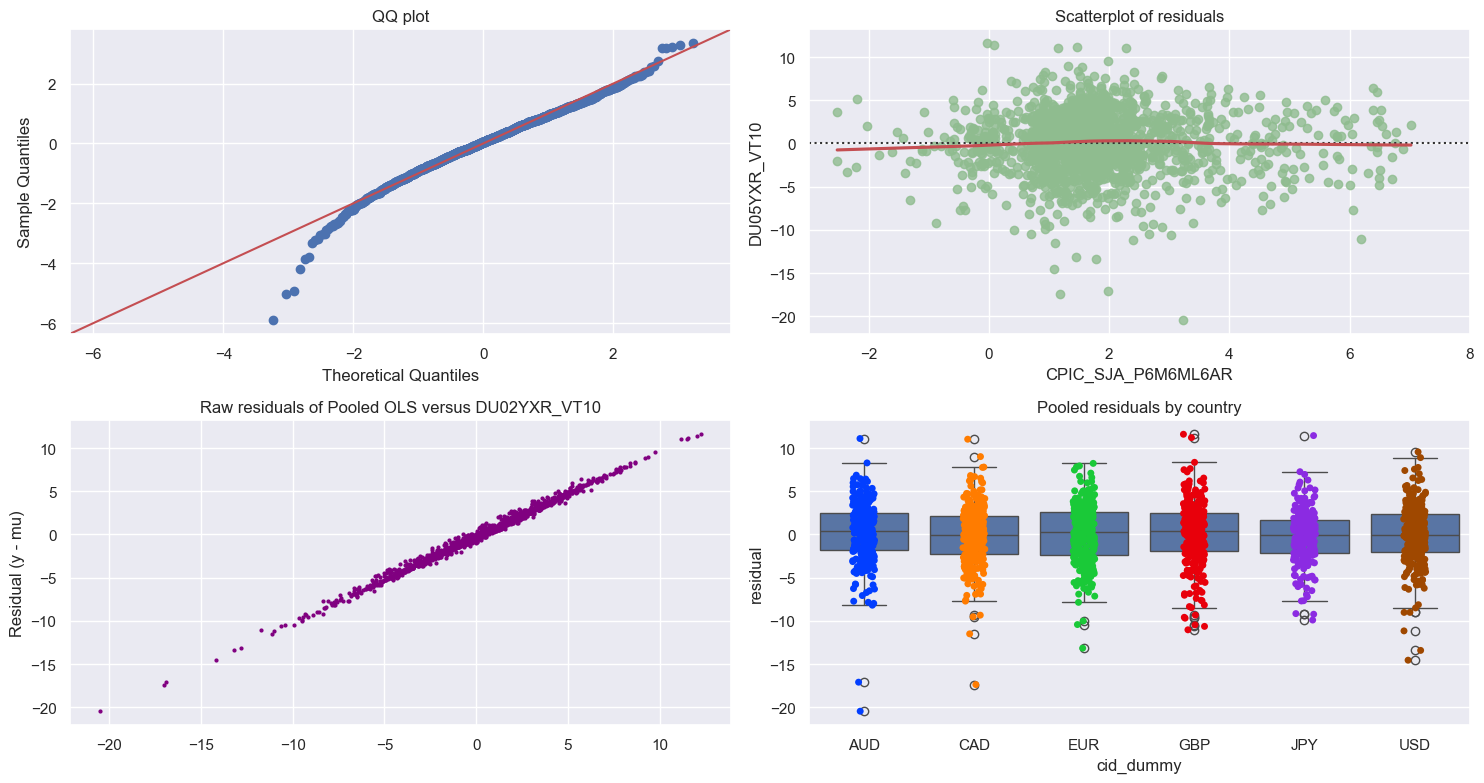

In [100]:
sns.set(rc={"figure.figsize": (15, 8)})
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2)


#left = -1.8   #x coordinate for text insert

sm.graphics.qqplot(lm_pooled.resids, line="45", fit=True, ax=ax1)
ax1.set_title("QQ plot")
top = ax1.get_ylim()[1] * 0.75


ax2.set_title("Scatterplot of residuals")
ax2.set_xlim((-3,8))
sns.residplot(
    x="CPIC_SJA_P6M6ML6AR",
    y="DU05YXR_VT10",
    data=dfx_pan,
    lowess=True,
    line_kws=dict(color="r"), color = "darkseagreen", ax=ax2
    )

ax3.set_title("Raw residuals of Pooled OLS versus DU02YXR_VT10")
ax3.set_ylabel("Residual (y - mu)")

ax3.scatter(
    dfx_pan.DU05YXR_VT10,
    lm_pooled.resids,
    s=4, 
    c="purple",
    label="Residual Error",
) 



dfx_pan["cid_dummy"] = dfx_pan.index.get_level_values(0).values

sns.boxplot(x="cid_dummy", y=lm_pooled.resids, data=dfx_pan)
g = sns.stripplot(x="cid_dummy", y=lm_pooled.resids, data=dfx_pan, palette="bright", ax=ax4) 
ax4.set_title("Pooled residuals by country")


fig.tight_layout()

plt.show()

Sometimes it is useful to ascertain that a relation holds roughly similarly across-sections (currency areas). The country-specific relations can be quickly visualized with Seaborn's `lmplot` function.

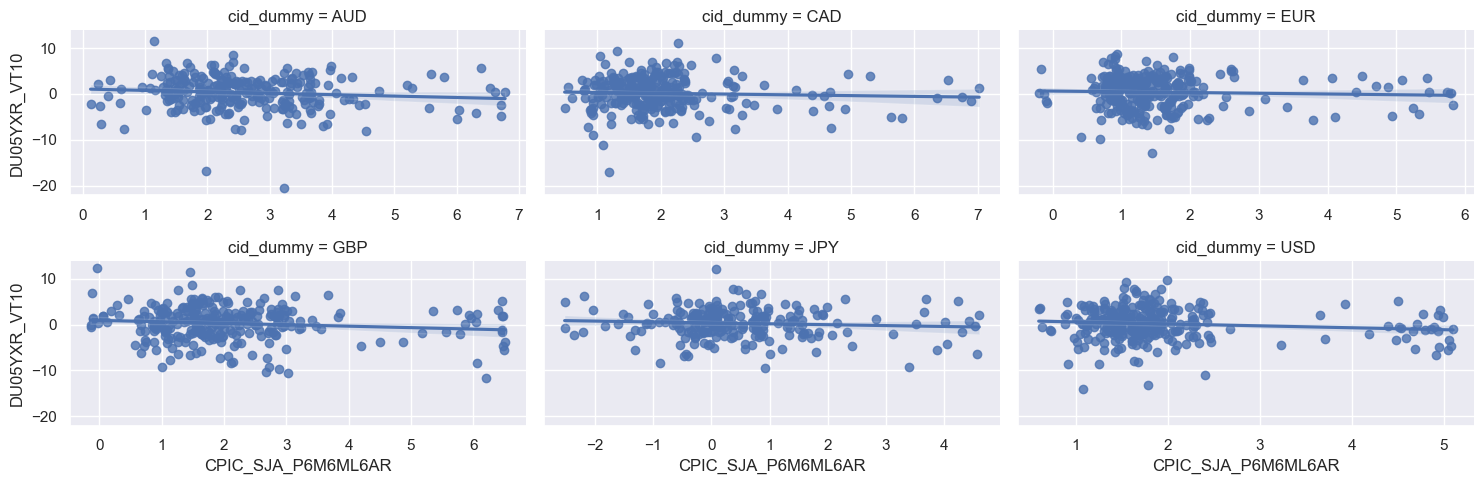

In [101]:
grid = sns.lmplot(
    x="CPIC_SJA_P6M6ML6AR",
    y="DU05YXR_VT10",
    col="cid_dummy",
    sharex=False,
    sharey=True,
    aspect = 2,
    
    col_wrap=3,
    data=dfx_pan,
    height=2.5,
)
fig.tight_layout()

# Fixed-effects regression

## Basics

Fixed effects in panel models are influences that are specific to a cross-section or a time period (or both). Also, they are assumed to be constant.
Fixed effects are conceptually viewed as unchangeable characteristics of the level, i.e. here of the cross-section or the observation period.

A good summary of the basic fixed-effects model can be found [on Wikipedia](https://en.wikipedia.org/wiki/Fixed_effects_model#:~:text=In%20statistics%2C%20a%20fixed%20effects,model%20parameters%20are%20random%20variables.)

Generally, fixed effects are useful to mitigate omitted variable biases, i.e. incorrect attribution of explanatory or predictive power of an unobserved variable to an observed one. For prediction models omitted variable biases are not always a fault. 
* If correlation between observed and unobserved variables is stable, using the observed feature and its estimated influence for forecasts is a valid strategy. 
* However, if the correlation between observed and unserved variable has been circumstantial and not expected to persist, the omitted variable bias will mislead the forecaster. In financial market research this danger typically arises for semi-structural features. For example, long-term averages of currency returns may be driven by risk premia. However, if an unrelated slow-moving semi-structural indicator has also recorded long-term differences across currency areas over the sample period, a pooled regression may easily misinterpret as predictors of risk premia.

Using fixed effects models for prediction bears its own risks. The model is misleading if cross-sectional differences reflect unobserved features that are actually changing over time. This concern applies, for example, to regressions on currency area-specific returns. While returns may have displayed significant differences historically, due for example to different risk premia, they plausibly reflect the specific history of the currency area over the sample period. The assumption of a stable return outperformance of a currency area, unrelated to any observable feature, is typically unrealistic.

As a rule of thumb, fixed-effects models should not be used for temporary effects. Cross-section fixed effects would be misleading and period-specific effects would just be useless for predictions.

## Using dummy variables and `statsmodels`

Fixed effects can be estimated with the `statsmodels` package by adding cross-section- or period-specific dummy variables to the `PooledOLS` method. The below estimation assumes that each currency area adds or subtracts a fixed premium to the target return.

In [123]:
X = [
    "CPIC_SJA_P6M6ML6AR",
   "cid_dummy",
]
X = sm.add_constant(dfx_pan[X])

sm_fe_cs = PooledOLS(dfx_pan.DU05YXR_VT10, X).fit(cov_type="clustered")

print(sm_fe_cs)

                          PooledOLS Estimation Summary                          
Dep. Variable:           DU05YXR_VT10   R-squared:                        0.0084
Estimator:                  PooledOLS   R-squared (Between):              1.0000
No. Observations:                1644   R-squared (Within):               0.0079
Date:                Sat, Apr 12 2025   R-squared (Overall):              0.0084
Time:                        10:21:39   Log-likelihood                   -4373.6
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.3117
Entities:                           6   P-value                           0.0316
Avg Obs:                       274.00   Distribution:                  F(6,1637)
Min Obs:                       226.00                                           
Max Obs:                       287.00   F-statistic (robust):             2.2548
                            

The constant in the above output applied the first (alphabetical - in our case AUD) market. The effects for other markets can be obtained adding the respective dummy coefficient values to the AUD level.  
The significance of fixed effects is indicated by the t-statistics and p-values of the dummy coefficients. Adding fixed effects for cross-section only increased the absolute value and strengthened the significance for chosen independent variable, though none of fixed effects are significant at 5% level.   

Fixed effects across periods can be analyzed similarly. However, with longer time series the output of the fixed-effects panel regression becomes vast and unreadable if we did look at the effects of every recorded period. Hence, here we use calendar years as a dummy variable and still include country as a dummy variable. 

In [103]:
dfx_pan["year"] = dfx_pan.index.get_level_values(1).year.astype("category")
dfx_pan["date"] = dfx_pan.index.get_level_values(1).astype("category")

X = [
    "CPIC_SJA_P6M6ML6AR",
    "cid_dummy",
"year"
]
X = sm.add_constant(dfx_pan[X])

sm_fe_time = PooledOLS(dfx_pan.DU05YXR_VT10, X).fit(cov_type="clustered")

print(sm_fe_time)

                          PooledOLS Estimation Summary                          
Dep. Variable:           DU05YXR_VT10   R-squared:                        0.0923
Estimator:                  PooledOLS   R-squared (Between):              1.0000
No. Observations:                1644   R-squared (Within):               0.0919
Date:                Sat, Apr 12 2025   R-squared (Overall):              0.0923
Time:                        09:03:21   Log-likelihood                   -4300.9
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.6619
Entities:                           6   P-value                           0.0000
Avg Obs:                       274.00   Distribution:                 F(29,1614)
Min Obs:                       226.00                                           
Max Obs:                       287.00   F-statistic (robust):             5.5063
                            

Even if the years' fixed effects are significant, this information is of little use for forecasting since time periods do not recur, however an interesting takeaway from the above summary is that, after having taken into account the effect of cross-section and year, there coefficient for inflation turns positive and looses any significance. 

## Fixed-effect regression with `linearmodels`

It is often more efficient to perform panel regression with the `statsmodels` extension [`linearmodels`](https://bashtage.github.io/linearmodels/). The `linearmodels` module focuses on panel regression, instrumental variable estimators, system estimators and models for estimating asset prices. The package needs to be be installed separately with `pip install linearmodels`. While fixed effects regression is similar to using dummy variables, it is computationally more efficient 

The `linearmodels` module features the class `PanelOLS`, which supports _one way_ (any unobserved effects that are different across individuals but fixed across time) and [two-way fixed effects](http://web.mit.edu/insong/www/pdf/FEmatch-twoway.pdf) estimation for panel data. This means one can consider cross-sectional effects (`entity_effects=True`) or period effects (`time_effects=True`) or both. However, `PanelOLS` only supports linear additive effects.

In [122]:
X = [
    "CPIC_SJA_P6M6ML6AR"]
X = sm.add_constant(dfx_pan[X])

lm_fe_cs = PanelOLS(
    dfx_pan.DU05YXR_VT10, X, time_effects=False, entity_effects=True
).fit(
    cov_type="clustered"
)  # clustering at cross-section level

print(lm_fe_cs)
print(lm_fe_cs.estimated_effects)

                          PanelOLS Estimation Summary                           
Dep. Variable:           DU05YXR_VT10   R-squared:                        0.0079
Estimator:                   PanelOLS   R-squared (Between):             -4.3148
No. Observations:                1644   R-squared (Within):               0.0079
Date:                Sat, Apr 12 2025   R-squared (Overall):              0.0062
Time:                        10:17:30   Log-likelihood                   -4373.6
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      13.067
Entities:                           6   P-value                           0.0003
Avg Obs:                       274.00   Distribution:                  F(1,1637)
Min Obs:                       226.00                                           
Max Obs:                       287.00   F-statistic (robust):             12.601
                            

The output above produces similar coefficient estimates and standard errors as pooled regression with dummy variables for each cross-section (`sm_fe_cs` in example above). The biggest difference in statistics comes from $R^2$ calculation: in the `linearmodels` Fixed Effects regression $R^2$ is given as "within $R^2$", which means that it devided the usual Sum Squared of Residuals on __demeaned__ Total sum of squared, encounting for the fixed effect.

An interesting statistics here is F-test for "poolability" and its p-value. A low p-value means high probability of effect significance and rejects the null hypothesis of no level-specific effects. This would be taken as an argument against poolability. By contrast, a high p-value of, say, above 0.1 means a lower probability of effect significance and would lend more support to using a pooled regression, which would be lest costly in terms of degrees of freedom.

Note that the summary does not display the fixed effect estimates (intercept). This is done to make the output compact: the model could potentially be used to analyse data with hundreds of "units" ("entities") and displaying all of them in one table 
would be counter-productive. 

The intercepts (constants) can be seen with command `lm_fe_cs.estimated_effects`, however they will be different numerically from pooled regression with dummy variables, where the benchmark was alphabetically first cross-section. To get numerically the same results the fixed effects should be called using formula below and after that the intercepts can be extracted. 


Below example replicates time fixed effects using `linearmodels`. It will be equivalent to pooledOLS using time and   "cid_dummy" as dummy variables. 

In [105]:
X = [
    "CPIC_SJA_P6M6ML6AR",
]
X = sm.add_constant(dfx_pan[X])

lm_fe_time = PanelOLS(
    dfx_pan.DU05YXR_VT10, X, time_effects=True, entity_effects=True
).fit(cov_type="clustered")

print(lm_fe_time)

                          PanelOLS Estimation Summary                           
Dep. Variable:           DU05YXR_VT10   R-squared:                        0.0004
Estimator:                   PanelOLS   R-squared (Between):              0.0170
No. Observations:                1644   R-squared (Within):               0.0030
Date:                Sat, Apr 12 2025   R-squared (Overall):              0.0030
Time:                        09:03:21   Log-likelihood                   -3382.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.5029
Entities:                           6   P-value                           0.4784
Avg Obs:                       274.00   Distribution:                  F(1,1351)
Min Obs:                       226.00                                           
Max Obs:                       287.00   F-statistic (robust):             0.4292
                            

The interesting part here is that taking into consideration the effect of cross-section and time, the significance of coefficient for `CPIC_SJA_P6M6ML6AR` has decreased and its coefficient is no longer significant. Again, the relevant F statistics shows support for pooled regression. The issue with two-way fixed effect model is a huge loss in degrees of freedom (having estimated each period and cross-section separately we loose 281 degrees of freedom). 

# Random effects regression

## Basics

Like fixed effects models, random effects models are used to account for cross-section- and period-specific effects. However, the purpose and assumptions of random effects models in financial markets research are different.

* <u>Random-effects models deal with the problem of pseudo-replication in panels</u>. Random effects are commonalities of measurements that are connected, for example by belonging to the same cross-section or time period. Affected observations are not independent. Treating them as independent leads to pseudo-replication and erroneous inference. For example, coefficient significance in a pooled OLS regression with pseudo-replication may be overstated. Random effects models are made for dealing with non-independence, as opposed to fixed effects, which focus on the actual parameter estimates of cross-section- or period-specific effects.
* Unlike fixed effects models, <u>random effects models do not consider omitted variable bias as a problem</u>. This often suits the purpose of financial market prediction models if one assumes that observed-unobserved variable correlation is stable. Then the observed feature can represent the effect of the unobserved one. After all, we care about forecast accuracy not about actual causality. 

Importantly, the term "random" does not mean that the effects are erratic or not measurable. They are merely influences that are not explained by the features of the model and are specific to the level, i.e. the period or the cross-section. In a random-effects model we consider level-specific commonalities as draws from a random variable and disregard their specific values. The effects themselves do not add any information we are interested in.

Conceptually, random effects represent a sample of all possible values or instances of that effect. Thus, they generalize to all results obtainable from the population. In the case of financial market panel research, they generalize to all possible cross-sections (markets, currency areas or countries) and time periods, including the future. This generalization typically makes the random effects model more suitable for predictions.

"Random effect estimates are a function of the group [cross-section or time period] level information as well as the overall (grand) mean of the random effect. Group levels with low sample size and/or poor information are more strongly influenced by the grand mean, which is serving to add information to an otherwise poorly-estimated group. However, a group with a large sample size and/or strong information  will have very little influence of the grand mean and largely reflect the information contained entirely within the group. This process is called partial pooling, as opposed to no pooling where no effect is considered or total pooling where separate models are run for the separate groups. Partial pooling results in the phenemenon known as shrinkage, which refers to the group-level estimates being shrink toward the mean. What does all this mean? If you use a random effect you should be prepared for your factor levels to have some influence from the overall mean of all levels. With a good, clear signal in each group, you won’t see much influence of the overall mean, but you will with small groups or those without much signal." [Steve Midway](https://bookdown.org/steve_midway/DAR/random-effects.html) 

## Cross-section random effects with `linearmodels` 

One way of performing cross-sectional random effects panel regression is to use the `RandomEffects` class of the `linearmodels` package. It implements a cross-sectional random effects model. 

In [106]:
X = sm.add_constant(dfx_pan["CPIC_SJA_P6M6ML6AR"])
lm_re = RandomEffects(dfx_pan.DU05YXR_VT10, X).fit(cov_type="clustered")
print(lm_re.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:           DU05YXR_VT10   R-squared:                        0.0066
Estimator:              RandomEffects   R-squared (Between):             -2.5876
No. Observations:                1644   R-squared (Within):               0.0076
Date:                Sat, Apr 12 2025   R-squared (Overall):              0.0066
Time:                        09:03:21   Log-likelihood                   -4375.1
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      10.886
Entities:                           6   P-value                           0.0010
Avg Obs:                       274.00   Distribution:                  F(1,1642)
Min Obs:                       226.00                                           
Max Obs:                       287.00   F-statistic (robust):             10.920
                            

The output is equivalent to the pooled regression. Adding cross-sectional random effect in this example does not much change results, as none of cross-sectional fixed effects was significant.

Generally, we can check the importance of random effects by extracting the "theta", a measure for the importance of the level, i.e. here the cross-sections, in explaining target variance. 

The random effects estimator makes use of a quasi-differenced model:

$y_{it} - \hat{\theta_i}\bar{y} = (1-\hat{\theta_i})\alpha_i + (x_{it} -\hat{\theta_i}x_i)\beta + (\epsilon_{it} - \hat{\theta_i}\bar{\epsilon})$ 

where y is the target, x the feature, the subscript i denotes a cross-section, and subscript t a period. Here $\hat\theta_i$ is a function of the variance of the cross-section specific error 
$\epsilon_{it}$, the variance of the intercepts $\alpha_i$ and the number of observations for entity $i$. The coefficient $\theta_i$ determines how much "demeaning" takes place. When this value is $0$, the random effects model effectively becomes a pooled model since this occurs when there is no variance in the effects. When  $\theta_i$ is $1$, the model effectively becomes a fixed effects model.

For example, in the above regression the $\theta_i$ is zero for all cross-sections, implying a no significant cross-section-specific effect. Put simply, the cross-section does not explain much of the variation of the return. This is plausible, because almost all of the return variation has to do with changeable market conditions rather than the country. For financial time series period-specific effects are often far more important than cross-section specific effects. 


In [107]:
print(lm_re.theta.transpose())

cid    AUD  CAD  EUR  GBP  JPY  USD
theta  0.0  0.0  0.0  0.0  0.0  0.0


Conveniently, the `compare` function of the `linearmodels.panel` module can be used to show the key output of different panel models side by side.

In [108]:
res = {
    "Pooled": lm_pooled,
    "One way fixed Effects": sm_fe_cs,
    "Random cross-section specific": lm_re,
    }
print(compare(res))

                                    Model Comparison                                    
                              Pooled One way fixed Effects Random cross-section specific
----------------------------------------------------------------------------------------
Dep. Variable           DU05YXR_VT10          DU05YXR_VT10                  DU05YXR_VT10
Estimator                  PooledOLS             PooledOLS                 RandomEffects
No. Observations                1644                  1644                          1644
Cov. Est.                  Clustered             Clustered                     Clustered
R-squared                     0.0066                0.0084                        0.0066
R-Squared (Within)            0.0076                0.0079                        0.0076
R-Squared (Between)          -2.5876                1.0000                       -2.5876
R-Squared (Overall)           0.0066                0.0084                        0.0066
F-statistic          

## Time period-specific random effects with `statsmodels` 

Period-specific random effects are often highly relevant for trading strategy research, as most targets are financial returns of the same type over different markets. The variation of this target is predominantly period-specific and often returns over the same period are highly correlated. Not accounting for such correlation leads to pseudo-replication of data and overstated significance of results. 

The Macrosynergy post [Testing macro trading factors](https://research.macrosynergy.com/testing-macro-trading-factors/) explains a period-specific random effects panel regression that is well suited for testing the influence of macro factors across countries. It is a practical and effective econometric technique to tackle pseudo-replication in panels. There is a R-script on [Kaggle](https://www.kaggle.com/code/macrosynergy/jpmaqs-panel-regression-r-code), replicating the result of the post. R offers better documentation and more flexibility for random/ linear mixed model effects than Python. This is done with two main packages - [`plm`](https://cran.r-project.org/web/packages/plm/plm.pdf) and [`lme4`](https://cran.r-project.org/web/packages/lme4/lme4.pdf). 

Here we replicate this procedure in Python. The easiest way to apply period-specific random effects in Python is to use mixed effects regression (`MixedLM`) from `statsmodels` package. The labeling of the function is, admittedly, a source of confusion. For practical purposes this function gives us the output of a period-specific random effects model, however.  Indeed Python in this case tries to replicate the output of R, using R packages as benchmark. 

In [109]:
y = dfx_pan["DU05YXR_VT10"]
X = dfx_pan["CPIC_SJA_P6M6ML6AR"]
X = sm.add_constant(X)

groups = dfx_pan.reset_index().real_date
re = sm.MixedLM(y,X,groups,).fit(reml=True) # Use restricted maximum likelihood
print(re.summary())

            Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  DU05YXR_VT10
No. Observations:  1644     Method:              REML        
No. Groups:        287      Scale:               4.3585      
Min. group size:   4        Log-Likelihood:      -3889.5652  
Max. group size:   6        Converged:           Yes         
Mean group size:   5.7                                       
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
const               0.445    0.198  2.250 0.024  0.057  0.832
CPIC_SJA_P6M6ML6AR -0.097    0.054 -1.797 0.072 -0.203  0.009
Group Var           7.694    0.373                           



The output of the model has less information than a standard OLS model or even a panel regression from linear model. The reason for that is that many of standard measurements are not applicable to the model:

* __Method__ states the fitting method (either Maximum Likelihood ([ML](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) or  [REML (Restricted maximum likelihood)](https://en.wikipedia.org/wiki/Restricted_maximum_likelihood)), a modified version of standard maximum likelihood. Mixed effects models can be difficult to fit and since they do not have closed form solutions they rely on an optimizer. Standard maximum likelihood often fails by not converging (the summary indicates if the model has converged or not). REML method often yields a better result. 
* The __Log-Likelihood__ value is the natural logarithm of probability of observing the sample data assuming it has been taken from a population that is characterized by the estimated parameters. It helps to compare different models. 
* The coefficients in the bottom part of the table for the intercept, and the covariates are __Fixed Effects__ of the mixed model. Comparing the output with the very first pooled regression model, we notice, that the negative relation between the month-end core CPI trend and next month’s return still shows as negative, but the statistical probability of this relation is only around 88%.
* The __Group Var__ coefficient actually is the variance of the period-specific random effects overtime. The term `Group` is generic but in this specific case, where we specified as group the `real_date` category, refers to time periods. 

__Scale__ is the (scalar) error variance. It is basically the estimated error variance based on given estimates
of the slopes and random effects covariance matrix. For discussion on its computation please see [source code with remarks](https://www.statsmodels.org/0.6.1/_modules/statsmodels/regression/mixed_linear_model.html#MixedLM.get_scale)

To estimate the importance of random factors we need to extract the scale and variance of the period-specific random effects from the model and simply divide variance of the period-specific random effects by the sum of two variances (and multiply by 100 to get percentage):

In [110]:
scale=sm.MixedLM(y,X,groups,).get_scale(re.fe_params, re.cov_re_unscaled, re.vcomp)
RE_explained=((re.cov_re/(re.cov_re+scale))*100).squeeze().round(2)
print ("% of Variance attributable to random factors time, in  %, is",  RE_explained)

% of Variance attributable to random factors time, in  %, is 63.84


The period-specific random effects can be extracted and plotted with the `.random_effects` method. For plotting see the mixed effects section below.

In [111]:
random_effects=pd.DataFrame.from_dict(re.random_effects)
random=random_effects.T
print(random.tail(5))

            Group Var
2023-08-31  -0.079231
2023-09-30  -2.522875
2023-10-31  -1.406765
2023-11-30   4.061640
2023-12-31   1.898387


To see how the model residuals are distributed against the fitted values and detect a possible pattern we can use a simple scatter plot

Text(0, 0.5, 'Residuals')

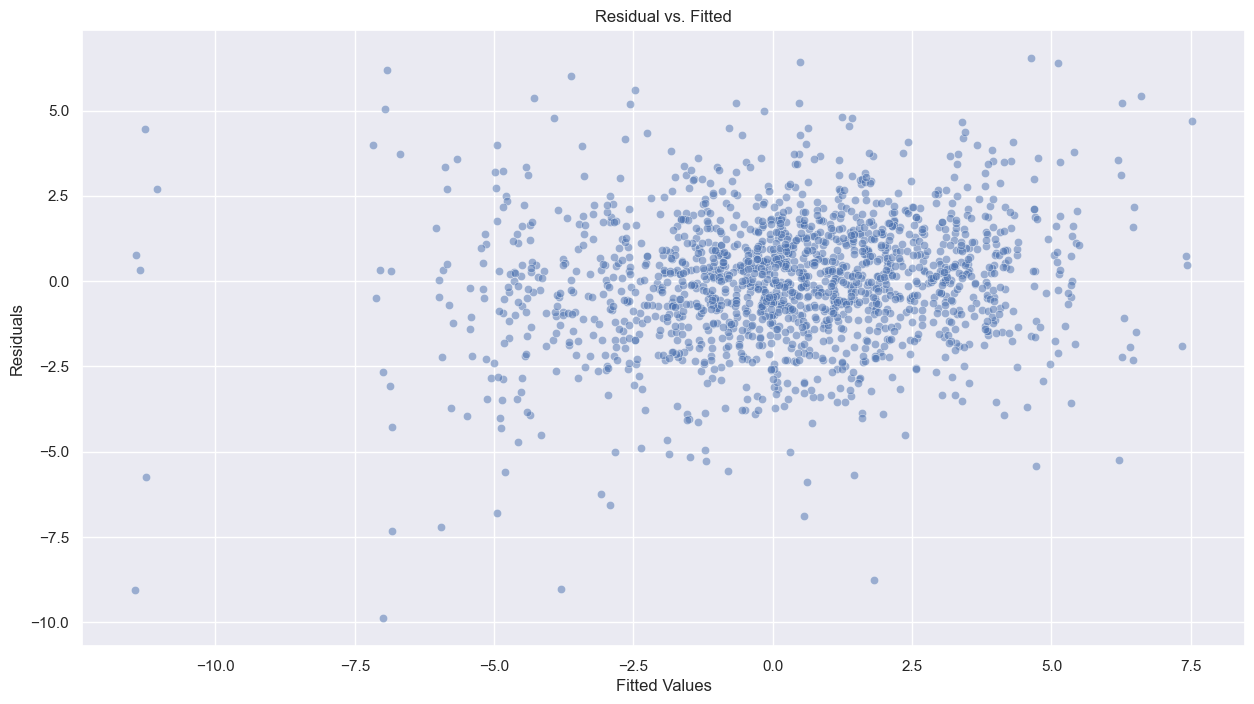

In [112]:
sns.scatterplot(x=(dfx_pan["DU05YXR_VT10"] - re.resid), y=re.resid, 
                   alpha = 0.5).set(title='Residual vs. Fitted')

plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

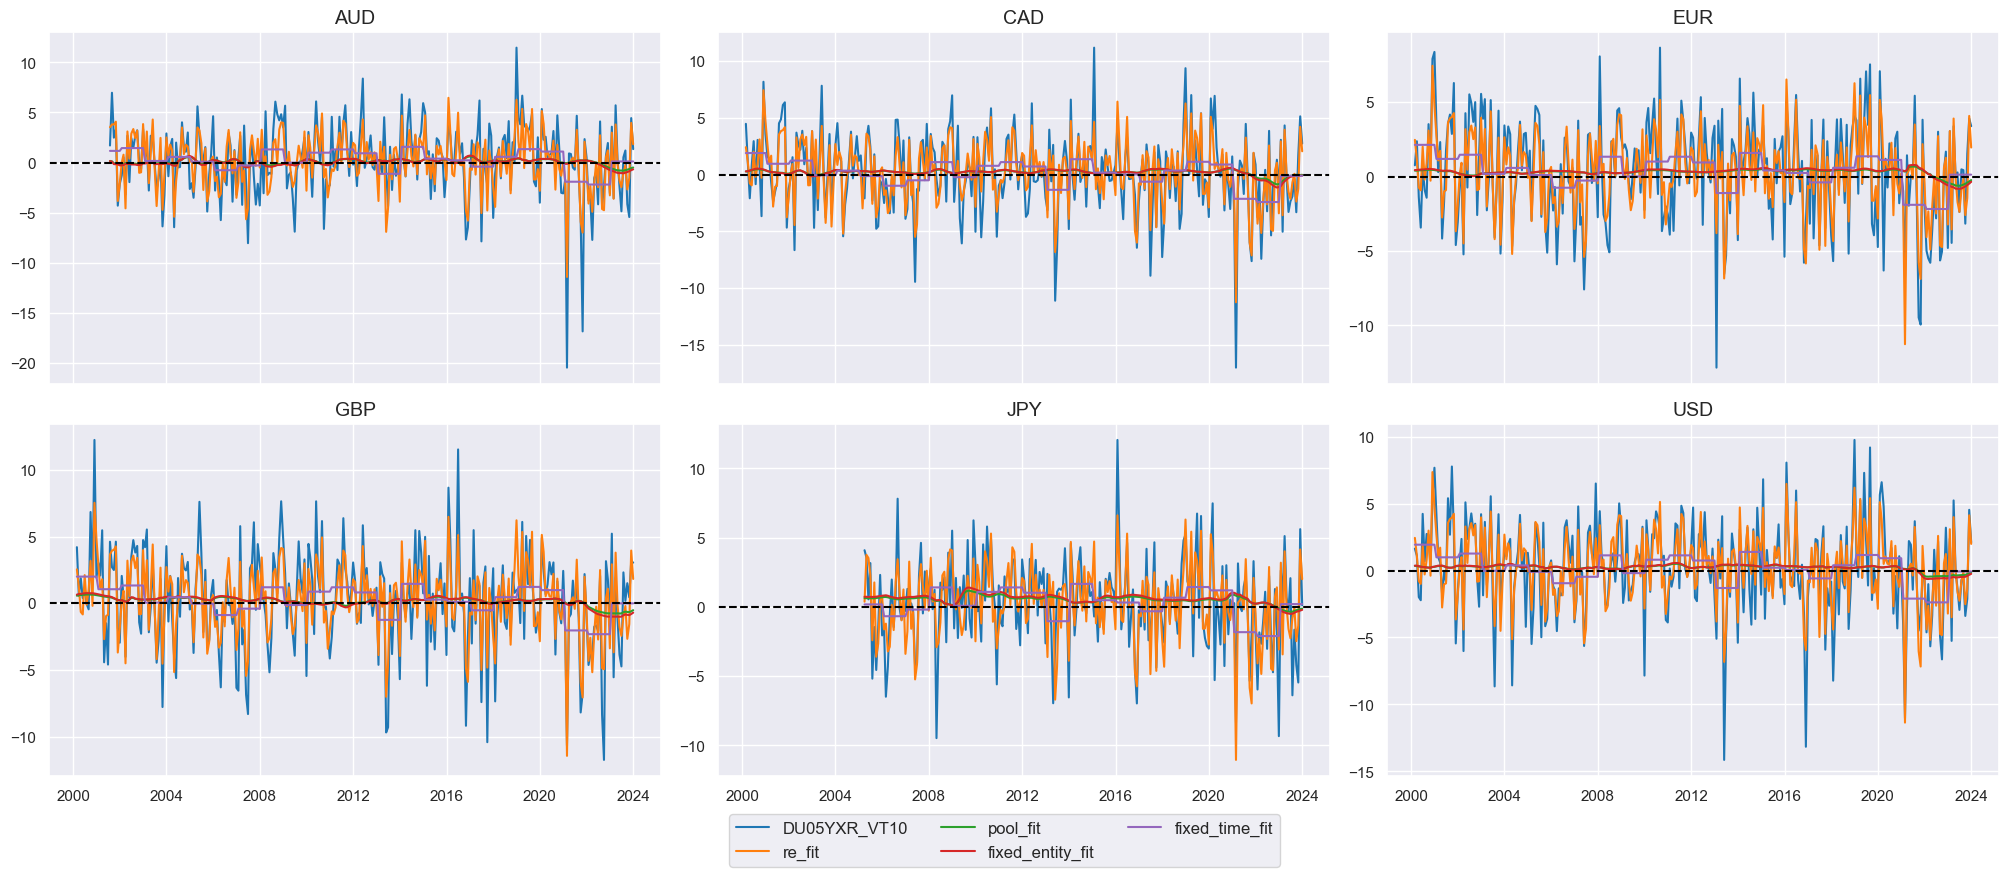

In [127]:
fitted = pd.DataFrame()

fitted["CPIC_SJA_P6M6ML6AR"] = dfx_pan.CPIC_SJA_P6M6ML6AR
fitted["DU05YXR_VT10"] = dfx_pan.DU05YXR_VT10

fitted["re_fit"] = re.fittedvalues
fitted["pool_fit"] = lm_pooled.fitted_values
fitted["fixed_entity_fit"]=lm_fe_cs.fitted_values
fitted["fixed_time_fit"]=sm_fe_time.fitted_values

fitted_l = fitted.reset_index()
fitted_l= pd.melt(fitted_l, 
   id_vars = ['cid', 'real_date'], 
   value_vars = ['CPIC_SJA_P6M6ML6AR', "DU05YXR_VT10", "re_fit", "pool_fit", "fixed_entity_fit", "fixed_time_fit"], 
   var_name = 'xcat', 
   value_name = 'value')

cidx= ["AUD", "CAD", "EUR", "GBP", "JPY", "USD"]

msp.view_timelines(
    fitted_l,
    xcats=["DU05YXR_VT10", "re_fit", "pool_fit", "fixed_entity_fit", "fixed_time_fit"],
    cids=cidx,
    ncol=3,
    start="2000-01-01",
    same_y=False,
    aspect=1.5,
    height=3,
    label_adj=0.2,
)

None of the models except for random effects predict much of the variation. It is to be expected as R-squared numbers were generally very low. The random effect model seems to capture much more.

# Linear mixed effects model

"The term 'mixed' or, more fully, 'mixed effects', denotes a model that incorporates both fixed- and random-effects terms in a linear predictor expression from which the conditional mean of the response can be evaluated." [Bates et al](https://www.academia.edu/63554620/Fitting_linear_mixed_effects_models_using_lme4). Note that this paper also describes the fitting of the model in `lme4` package and part of this package is replicated in Python's `statsmodels` under `smf.mixedlm` model. 

"Linear mixed-effects models are an important class of statistical models that can be used to analyze...continuous, hierarchical data...taking into account the correlation of observations...They allow us to effectively partition overall variation of the dependent variable into components corresponding to different levels of data hierarchy." Gałecki and Burzykowski

The practical benefits of this type of model are <u>flexibility to introduce level-specific effects to intercepts and slopes</u>. In particular, one can specify random intercept *and* random slope coefficients. As before, the model will estimate fixed coefficients  For example, these models allow random intercepts with fixed means, intercept that vary across a level and a sub-level, correlated random intercepts and slopes, and uncorrelated intercept and slopes. Formally the model posits that the conditional distribution of a target vector for a realized set of level-specific random effects is normal around a linear combination of features, the random effects and, possibly, a prior offset term.

Linear mixed effects models also offer more flexibility in handling unbalanced repeated measures data. It is important to determine which effects should have random components and which should be fixed. The model is iterative: a tentative model is fitted and consequently modified to generate a better fit. In general this model does not have a closed-form solution, so convergence is required for the model to work. For more than one covariate the user can decide on parameter by parameter basis what regressors should be considered as random. For model specifications please see [here](https://www.statsmodels.org/dev/mixed_linear.html)

Basic documentations with methods description can be viewed [here](https://www.statsmodels.org/dev/generated/statsmodels.regression.mixed_linear_model.MixedLM.html#statsmodels.regression.mixed_linear_model.MixedLM). Use of formula is described [here](https://www.statsmodels.org/dev/generated/statsmodels.regression.mixed_linear_model.MixedLM.from_formula.html). And the results are discussed [here](https://www.statsmodels.org/dev/generated/statsmodels.regression.mixed_linear_model.MixedLMResults.html#statsmodels.regression.mixed_linear_model.MixedLMResults)

In the first example we use the group (the cross-sections) intercepts and slope coefficients as random factors. Compared to the above pooled regression model the panel estimates of the intercept and slope coefficients only change slightly, reflecting that the explanatory power of cross-sections for monthly duration returns is marginal.

In [114]:
groups = dfx_pan.reset_index().cid
lmm1 = smf.mixedlm("DU05YXR_VT10 ~ CPIC_SJA_P6M6ML6AR", dfx_pan, groups=groups,
                       re_formula="1+CPIC_SJA_P6M6ML6AR").fit()
print(lmm1.summary())

                  Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      DU05YXR_VT10
No. Observations:      1644         Method:                  REML        
No. Groups:            6            Scale:                   12.0111     
Min. group size:       226          Log-Likelihood:          -4378.5694  
Max. group size:       287          Converged:               No          
Mean group size:       274.0                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.631    0.164  3.853 0.000  0.310  0.952
CPIC_SJA_P6M6ML6AR             -0.214    0.067 -3.204 0.001 -0.346 -0.083
Group Var                       0.002    0.023                           
Group x CPIC_SJA_P6M6ML6AR Cov -0.001    0.003          

However, unlike in the pooled model we can now derive cross-section specific intercepts and - more importantly - slope coefficients by accessing the `random_effects` attribute. 

This can be very important for prediction if we have reason to believe that the cross-sectional differences of elasticities are, to some extent, persistent. In this case considering cross-section specific slope coefficient can deliver better predictions than the panel or pool coefficient. The conditional means of random effects given the data can be extracted with property [`random_effects`](https://www.statsmodels.org/dev/generated/statsmodels.regression.mixed_linear_model.MixedLMResults.random_effects.html#statsmodels.regression.mixed_linear_model.MixedLMResults.random_effects):

In [115]:
print(pd.DataFrame.from_dict(lmm1.random_effects), "\n")
print("Fixed effects for linear mixed effects model with cid as random factor are \n", lmm1.fe_params)

                         AUD       CAD       EUR       GBP       JPY       USD
Group              -0.000471 -0.000817 -0.001048  0.004335 -0.007016  0.005017
CPIC_SJA_P6M6ML6AR  0.002202 -0.000015  0.001587 -0.002843  0.003546 -0.004477 

Fixed effects for linear mixed effects model with cid as random factor are 
 Intercept             0.630880
CPIC_SJA_P6M6ML6AR   -0.214473
dtype: float64


# Seemingly unrelated regressions

The seemingly unrelated regressions model (`SUR`), as proposed by [A. Zellner](https://en.wikipedia.org/wiki/Seemingly_unrelated_regressions), can be applied to panel data if one wishes to estimate level-specific coefficients, such as a cross-section specific slope coefficient. It is a generalization of linear regression model that consists of multiple cross-sectional equations, each having its own set of features.  SUR seek to increase the efficiency of estimation by accounting for correlations in unobserved shocks.

Each cross-section runs its own a linear regression but the error terms may be correlated across-sections. This may reflect common or global shocks, which are a plausible assumption for asset return panels. The equations are called seemingly unrelated because they are only related through the error terms. Technically speaking, equations may be linked through the jointness of the distribution of the error terms and through the non-diagonal covariance matrix.  If the error terms are uncorrelated, SUR will produce the same results as independent cross-section regressions (and separate OLS regressions will be truly unrelated). If error terms are indeed correlated, SUR will enhance parameter estimation efficiency relative to independent cross-section regressions. 

The model is estimated in two steps: Firstly the OLS (or GLS) is run for all cross- sections and residuals from this regressions are calculated. In the second step the generalized least squares regression is run using the residuals from the first step. SUR also allows to use different set of regressors across cross-section. For example, we do not consider inflation in developed markets as relevant estimator, we can exclude it from regression for selected markets and leave it for developing markets.


The main advantages of SUR are: Joint inference across models, improved precision of parameters, possibility of inclusion of different covariates in separate models and the model allows adding linear constrains to the model.

Like OLS, the SUR method assumes that all the regressors are independent variables, all individual equations are assumed to have homoskedastic iid errors. Consequently, similar critique can be applied to SUR as to a standard ols regression. Also, Python standard implementation does not support unbalanced panels, so we will be loosing information, needing to cut the longest time series to the size of the shortest. 

The model specification used in Python can be found [here](https://bashtage.github.io/linearmodels/system/system/linearmodels.system.model.SUR.html)

In [131]:
from collections import OrderedDict

shared_cids = ["EUR", "GBP"]
# shared_cids = ["USD", "EUR", "CAD", "GBP"]  #, "JPY", "AUD"]

dfx_pan["Intercept"] = 1.0
dfx_pan_modified = OrderedDict()

for region in shared_cids:
    region_dfx = dfx_pan.loc[region]
    y = region_dfx.DU05YXR_VT10
    X = region_dfx[[  "Intercept",
        "CPIC_SJA_P6M6ML6AR",
   
    ]]

    dfx_pan_modified[region] = {"dependent": y, "exog": X}
    sm_sur = SUR(dfx_pan_modified).fit(cov_type="clustered", method="GLS")

sm_sur

System GLS Estimation Summary                           
===================================================================================
Estimator:                        GLS   Overall R-squared:                   0.0069
No. Equations.:                     2   McElroy's R-squared:                 0.0033
No. Observations:                 287   Judge's (OLS) R-squared:             0.0069
Date:                Sat, Apr 12 2025   Berndt's R-squared:                 -0.0014
Time:                        10:59:32   Dhrymes's R-squared:                 0.0069
                                        Cov. Estimator:                   clustered
                                        Num. Constraints:                      None
                   Equation: EUR, Dependent Variable: DU05YXR_VT10                    
======================================================================================
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Intercept              0.5887     0.3094     1.9029     0.0571     -0.0176      1.1950
CPIC_SJA_P6M6ML6AR    -0.1404     0.1381    -1.0164     0.3095     -0.4110      0.1303
                   Equation: GBP, Dependent Variable: DU05YXR_VT10                    
======================================================================================
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Intercept              0.5790     0.3291     1.7595     0.0785     -0.0660      1.2241
CPIC_SJA_P6M6ML6AR    -0.1606     0.1247    -1.2877     0.1979     -0.4050      0.0838
======================================================================================

Covariance Estimator:
Heteroskedastic (Robust) Covariance (Debiased: False, GLS: True, Number of Grouping Variables: 0, Group Debias: False)
SystemResults, id: 0x28f145ee7d0

The output of `SUR` regressions is similar to standard ols model with its usual statistics for coefficients. It only adds few variations of $R^2$ as measure of goodness of fit parameters: The formulas for each $R^2$ can be found in doc for [SUR regressions](https://bashtage.github.io/linearmodels/system/mathematical-formula.html#). The model achieves reduction of coefficient estimator variances compared with those of equation-by-equation least-square, hence confidence intervals for the coefficients are tighter. However none of the coefficients in our example are significant. P-values are well above the usual threashhold of 0.05 for all markets. 

To check if `SUR` improves efficiency of parameters, we check correlation of residuals and print summary of coefficients. It is clear, that error terms of chosen parameters display significant correlation, and hence `SUR` will : 

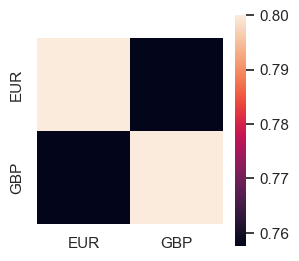

Parameters of SUR regression
[Intercept             0.588700
CPIC_SJA_P6M6ML6AR   -0.140358
Name: params, dtype: float64, Intercept             0.579037
CPIC_SJA_P6M6ML6AR   -0.160565
Name: params, dtype: float64]
<class 'list'>
        Intercept  CPIC_SJA_P6M6ML6AR
params   0.588700           -0.140358
params   0.579037           -0.160565


In [132]:
cov = sm_sur.sigma
std = np.sqrt(np.diag(sm_sur.sigma)[:, None])
regions = [k for k in dfx_pan_modified.keys()]
corr = pd.DataFrame(cov / (std @ std.T), columns=shared_cids, index=shared_cids)

fig, ax = plt.subplots(figsize=(3, 3))
sns.heatmap(corr, vmax=0.8, square=True)
plt.show()

corr.style.format("{:0.3f}")

print("Parameters of SUR regression")

params = []
for label in sm_sur.equation_labels:
    params.append(sm_sur.equations[label].params)
print(params)
print(type(params))
params = pd.DataFrame(params)
print(params)
params.columns = sm_sur.equation_labels
params = params.T.style.format("{:0.3f}").data.sort_index()

sur_params=params


To compare coefficients for single market we can just run a simple OLS regression for each market and compare the results side by side:

In [133]:
params = []



for cid in shared_cids:

    dfx_pan_cid = dfx_pan.loc[dfx_pan.index.get_level_values("cid") == cid]
    X = dfx_pan_cid[
         [
           "Intercept",
           "CPIC_SJA_P6M6ML6AR",
           
         ]
     ]
    y = dfx_pan_cid.DU05YXR_VT10
    OLS_cid = sm.OLS(y, X).fit()
    params.append(OLS_cid.params)


params = pd.DataFrame(params)
params.columns = shared_cids

OLS_params=params.T.style.format("{:0.3f}")
OLS_params = OLS_params.data


In [134]:
cids = ["GBP"]
for cid in cids:

    dfx_pan_cid = dfx_pan.loc[dfx_pan.index.get_level_values("cid") == cid]

    X = dfx_pan_cid[
         [
           "Intercept",
           "CPIC_SJA_P6M6ML6AR",
           
         ]
     ]
    y = dfx_pan_cid.DU05YXR_VT10
    OLS_cid = sm.OLS(y, X).fit()

print(OLS_cid.params)
print(OLS_cid.pvalues)

Intercept             0.908839
CPIC_SJA_P6M6ML6AR   -0.317422
dtype: float64
Intercept             0.019960
CPIC_SJA_P6M6ML6AR    0.040059
dtype: float64


In [135]:
result = pd.concat([OLS_params, sur_params], axis=1, join="inner")
result.columns = pd.MultiIndex.from_tuples(
    zip(['OLS Results', '', 'SUR Results', ''], 
        result.columns))
result

,OLS Results,,SUR Results,
,0,1,params,params
EUR,0.618286,0.908839,0.588700,0.579037
GBP,-0.159422,-0.317422,-0.140358,-0.160565
